In [465]:
from theano.sandbox import cuda
cuda.use('gpu0')
import tensorflow
import os, sys
current_dir = os.getcwd()
from keras.layers import Merge
import time
# import imageio
from keras.models import model_from_json
import bcolz
import pdb
import tensorflow as tf
import pandas as pd
from keras.callbacks import LearningRateScheduler
from model import *

In [466]:
import utils; reload(utils)
import model; reload(model)
from model import *
from utils import *
from IPython.display import FileLink
%matplotlib inline
from random import shuffle

In [467]:
seed = 7
np.random.seed(seed)

In [468]:
vi = visualization()
dh = data_handler()
laser, rgb, depth, ret = dh.load(data_path = 'data/sensor/')

laser_shuffle = []
rgb_shuffle = []
depth_shuffle = []
index_shuf = range(laser.shape[0])
shuffle(index_shuf)
for i in index_shuf:
    laser_shuffle.append(laser[i])
    rgb_shuffle.append(rgb[i])
    depth_shuffle.append(depth[i])

In [469]:
laser = np.array(laser_shuffle)
rgb = np.array(rgb_shuffle)
depth = np.array(depth_shuffle)

# km = keras_model(output_shape = laser.shape[1])

print 'Laser: ' + str(laser.shape)
print 'Depth: ' + str(depth.shape)
print 'RGB: ' + str(rgb.shape)
N = laser.shape[0]
rgb_train = rgb

batch_size = 64
no_of_epochs = 1
# km.compile()

Laser: (5843, 233)
Depth: (5843, 40, 640, 1)
RGB: (5843, 40, 640, 3)


In [470]:
# km.final_model.fit([depth, rgb], laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size,callbacks=[km.tbCallback, km.lrate])

In [471]:
def mean_squared_error_exp(y_true, y_pred):
#     diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.square(tf.maximum(0.,y_pred-y_true)),axis=-1) + K.mean(K.square(tf.maximum(0.,-(y_pred+0.5))),axis=-1)
#+ K.mean(tf.log(1.+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+10.*K.mean(tf.log(1.+tf.exp(10.*(-y_pred+0.3))),axis=-1)+K.mean(tf.log(1+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+100. * K.mean(diff, axis=-1)
# (1e-6/(1+tf.exp(y_pred*100-0.3)

In [472]:
def conv1():
    rgb_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,3)),
            Convolution2D(16,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(16,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,3)),
            BatchNormalization(axis=1),
            Convolution2D(64,1,3, activation='relu',dim_ordering = 'tf'),
#             Convolution2D(32,1,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((1,4)),
            BatchNormalization(axis=1),
#             MaxPooling2D((1,3)),
#             Convolution2D(64,1,11, activation='relu',dim_ordering = 'tf'),
#             MaxPooling2D((2,3)),
            Flatten()
#             Dense(200, activation='relu'),
#             BatchNormalization(),
#             Dense(233, activation='linear')
        ])
    depth_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,1)),
            Convolution2D(16,3,3, activation='linear',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(16,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            Convolution2D(64,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(64,1,3, activation='relu',dim_ordering = 'tf'),
            AveragePooling2D((2,4)),
            BatchNormalization(axis=1),
#             Convolution2D(128,1,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
#             AveragePooling2D((2,5)),
#             BatchNormalization(axis=1),
            Flatten()
#             Dense(640, activation='relu')
#             Dense(512, activation='relu')
#             Dense(640, activation='relu')
#             BatchNormalization()
#             Dense(233, activation='linear')
        ]) 
    final_model = Sequential()
    final_model.add(Merge([rgb_model, depth_model],mode='concat'))
    final_model.add(Dropout(0.6))
    final_model.add(BatchNormalization())
    final_model.add(Dense(512, activation='relu',init='lecun_uniform'))
    final_model.add(Dropout(0.5))
    final_model.add(BatchNormalization())
    final_model.add(Dense(233, activation='linear', init='lecun_uniform'))
    

#     model.fit_generator([rgb, laser],laser.shape[0], nb_epoch=no_of_epochs)
#     model.optimizer.lr = 0.001
#     model.fit_generator(depth, laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size)
    return final_model

model = conv1()
sgd = SGD(lr=0.0, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss='mse')
# mean_squared_error_exp

In [473]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_245 (BatchNor (None, 40, 640, 3)    160                                          
____________________________________________________________________________________________________
convolution2d_176 (Convolution2D (None, 38, 638, 16)   448                                          
____________________________________________________________________________________________________
maxpooling2d_76 (MaxPooling2D)   (None, 19, 319, 16)   0                                            
____________________________________________________________________________________________________
batchnormalization_246 (BatchNor (None, 19, 319, 16)   76                                           
___________________________________________________________________________________________

In [474]:
#model.load_weights('models/model_notebook.h5')

In [475]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [476]:
# model.optimizer.lr=0.1
# tbCallback=keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

In [488]:
N_s = 0
N = N_s + 5800
laser_s = laser[N_s:N,:]
rgb_s = rgb[N_s:N,:,:,:]
depth_s = depth[N_s:N,:,:]
batch_size = 64
no_of_epochs = 100
# validation_split = 0.2
model.fit([rgb_s,depth_s], laser_s, nb_epoch=no_of_epochs, validation_split = 0.2, batch_size=batch_size,callbacks=[lrate])

Train on 4640 samples, validate on 1160 samples
Epoch 1/100
4640/4640 [==============================] - 355s - loss: 1.1810 - val_loss: 1.8942
Epoch 2/100
4640/4640 [==============================] - 348s - loss: 1.1982 - val_loss: 1.5933
Epoch 3/100
4640/4640 [==============================] - 237s - loss: 1.2346 - val_loss: 3.7400
Epoch 4/100
4640/4640 [==============================] - 436s - loss: 1.2216 - val_loss: 1.6833
Epoch 5/100
4640/4640 [==============================] - 434s - loss: 1.2013 - val_loss: 1.6947
Epoch 6/100
4640/4640 [==============================] - 457s - loss: 1.2210 - val_loss: 7.7775
Epoch 7/100
4640/4640 [==============================] - 440s - loss: 1.2519 - val_loss: 1.6986
Epoch 8/100
4640/4640 [==============================] - 437s - loss: 1.2018 - val_loss: 1.7011
Epoch 9/100
4640/4640 [==============================] - 437s - loss: 1.1908 - val_loss: 1.5627
Epoch 10/100
4640/4640 [==============================] - 438s - loss: 1.1426 - val_loss

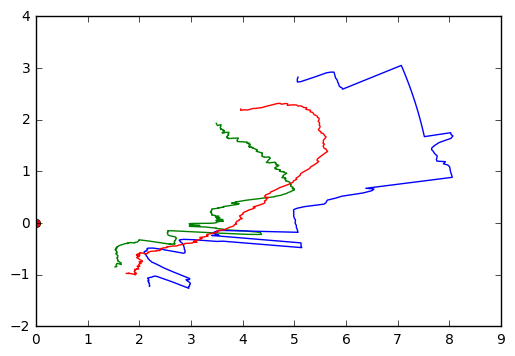

In [496]:
N = 4500
# result = model.predict([depth[N:N+1,:,:,:]])
result = model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
pose = [0.,0.,0.]
vi.depth_plot(np.mean(depth[N,15:35,:,:],axis=0),pose)
vi.laser_plot(laser[N,:],pose)
vi.laser_plot2(result[0],pose)
plt.plot(0,0,'or')

In [479]:
result

array([[ 5.5462,  5.9255,  5.8131,  5.8064,  5.87  ,  5.9383,  5.6221,  5.4509,  5.7628,  5.6558,
         5.4509,  5.886 ,  6.0673,  5.9164,  5.9588,  6.1558,  5.9831,  6.0311,  5.8331,  5.6036,
         5.6095,  5.2757,  5.5735,  5.4374,  5.4898,  5.456 ,  5.465 ,  5.3735,  5.0352,  4.8171,
         4.9657,  4.8404,  4.58  ,  4.7014,  4.5618,  4.6617,  4.7934,  4.954 ,  4.9521,  5.0212,
         5.0552,  5.0527,  4.9574,  5.2319,  5.0851,  5.2047,  5.3807,  5.3234,  5.5696,  5.3723,
         5.6918,  5.5558,  5.4399,  5.6571,  5.5447,  5.3257,  5.3109,  5.077 ,  5.4054,  5.4006,
         5.3415,  5.3605,  5.4141,  5.176 ,  5.2676,  4.9509,  5.0203,  5.206 ,  5.0897,  5.0747,
         5.1385,  4.8448,  4.885 ,  5.0117,  5.0023,  4.8284,  4.921 ,  4.8648,  5.0365,  4.9051,
         5.0637,  4.7242,  4.9003,  4.999 ,  4.6692,  4.9293,  4.7317,  4.8337,  4.518 ,  4.6623,
         4.8582,  4.7707,  4.7154,  4.5785,  4.5488,  4.7771,  4.8737,  4.6738,  4.8156,  5.0425,
         4.9304,  5.

In [497]:
model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
json_file.close()
model.save_weights("models/model_notebook.h5")
print("Saved model to disk")

Saved model to disk
